# This script takes subject id and looks for log files associated with it and calculates performace metrics for particular subject. 

In [550]:
import os
import glob as glob
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from datetime import datetime
from dateutil.parser import parse

def logFile2Table(path):
    '''
    logFile2Table function takes log file and outputs Following:
    1) Header string from the log file which records time stamp
    2) Event Table
    3) response table
    '''
#     infile = r'/Users/manasibhogawar/Desktop/BEEIGL/logfiles/02_S0300_v0-r3hvAm.log'
    infile = path
    with open(infile) as f:
        f = f.readlines()
    imp = []
    important1 = []
    important2 = []

    read = True
    for line in f:
        if line.startswith("Subject\tTrial\t"):
            read = False

        if read:    
            imp.append(line)

    header_table = [l.rstrip() for l in imp if l != ' '][:-1]
    #header_table.head()


    # Fetching log file data of Event table
    for line in f:
        if line.startswith("Subject\tTrial\t") :
            read = False
        elif line.startswith("Event Type\tCode"):
            read = True
    #     if line.startswith("Event Type\tCode"):
    # #         endofLines = True
    #     if not line.startswith("Event Type\tCode") or nextlines:
        if read:
            important2.append(line)

    l2 = [l.rstrip().split('\t') for l in important2 if l != '\n']
    event_table = pd.DataFrame(l2)
    event_table.head()
    ##event_table.info()


    # Fetching log file data of Event table
    read = False
    for line in f:
        if line.startswith("Subject\tTrial\t") :
            read = True
        elif line.startswith("Event Type\tCode"):
            read = False
    #     if line.startswith("Event Type\tCode"):
    # #         endofLines = True
    #     if not line.startswith("Event Type\tCode") or nextlines:
        if read:
            important1.append(line)

    l1 = [l.rstrip().split('\t') for l in important1 if l != '\n']
    stim_table = pd.DataFrame(l1)
    stim_table.head()
    
    event_table = event_table.rename(columns=event_table.iloc[0]).drop(event_table.index[0])
    stim_table = stim_table.rename(columns=stim_table.iloc[0]).drop(stim_table.index[0])
    
    return event_table, stim_table, header_table



def Statscal(b):    
    ''' 
    This function takes reponse table and calculates
    response time column, # of hits, misses and false alarm.
    '''    
    #Calculating response time
    b['ResponseTime'] = b.Time.diff()
    response_time = b.loc[b['Event Type'] == "Response"]
    #Count of number of Hits for vertical targets
    b["VerticalblueImage"] = b['Code'].str.contains('blue0')   #this will mark column where code is something like blue* 
    b["HorizontalblueImage"] = b['Code'].str.contains('blue1')
    b["isHit"] = "No Hits"     # by default we mark all as no hit
    # in this loop we will check if the row which has blue image also have ["Event Type"]=='Response' in next row. 
    #then mark that row as hit
    for i in range(1,len(b)):
        currentrow = b.iloc[i]
        if (i+1<len(b)):
            nextrow = b.iloc[i+1]
        if currentrow["VerticalblueImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isHit"]]="VerticalTargetHit"
        if currentrow["HorizontalblueImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isHit"]]="HorizontalTargetHit"
            
#             b["isHit"] = (b["VerticalblueImage"]=="VerticalTargetHit")
#             b["isHit"] = (b["HorizontalblueImage"]=="HorizontalTargetHit")
    VerticalHits = (b.isHit == "VerticalTargetHit").sum()
    HorizontalHits = (b.isHit == "HorizontalTargetHit").sum()
    Hits = VerticalHits + HorizontalHits   
    
    #Count the number of false alarm 
    b["VerticalfullImage"] = b['Code'].str.contains('full0')   #this will mark column where code is something like full*
    b["HorizontalfullImage"] = b['Code'].str.contains('full1')
    b["isFalseAlarm"] = "No FalseAlarm"     # by default we mark all as no false alarm
    # in this loop we will check if the row which has full image also have ["Event Type"]=='Response' in next row. then mark that
    # row as false alarm
    for i in range(1,len(b)):
        currentrow = b.iloc[i]
        if (i+1<len(b)):
            nextrow = b.iloc[i+1]
        if currentrow["VerticalfullImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isFalseAlarm"]]="VerticalFalseAlarm"
        if currentrow["HorizontalfullImage"] and (nextrow["Event Type"]=='Response'):
            b.loc[i,["isFalseAlarm"]]="HorizontalFalseAlarm"
            
    VerticalFalse_Alarm = (b.isFalseAlarm == "VerticalFalseAlarm").sum()
    HorizontalFalse_Alarm = (b.isFalseAlarm == "HorizontalFalseAlarm").sum()
    False_Alarm = VerticalFalse_Alarm + HorizontalFalse_Alarm
    
    #Count of number of  Target Miss
    b["VerticalblueImage"] = b['Code'].str.contains('blue0')   #this will mark column where code is something like blue* 
    b["HorizontalblueImage"] = b['Code'].str.contains('blue1')
    b["isMiss"] = "No Miss"     # by default we mark all as no hit
    # in this loop we will check if the row which has blue image also have ["Event Type"]=='Response' in next row. then mark that
    # row as hit
    for i in range(1,len(b)):
        currentrow = b.iloc[i]
        if (i+1<len(b)):
            nextrow = b.iloc[i+1]
        if currentrow["VerticalblueImage"] and (nextrow["Event Type"]!='Response'):
             b.loc[i,["isMiss"]]="VerticalTargetMiss"
        if currentrow["HorizontalblueImage"] and (nextrow["Event Type"]!='Response'):
            b.loc[i,["isMiss"]]="HorizontalTargetMiss"
                                                           
    VerticalMiss_Counts = (b.isMiss == "VerticalTargetMiss").sum()
    HorizontalMiss_Counts = (b.isMiss == "HorizontalTargetMiss").sum()
    Miss_Counts = VerticalMiss_Counts + HorizontalMiss_Counts
    
    return response_time["ResponseTime"].dropna().to_list() ,Hits, False_Alarm, Miss_Counts

In [551]:
#main function which calls all other utility functions

inprocess = "/Users/manasibhogawar/Desktop/Temp/"  # INprocess directory stores all tables in csv format
timestamps_table = {}
Response_table = {}
hits= {}
miss={}
falseAlarm={}
ordered_timestamps = {}

filenames = glob.glob('/Users/manasibhogawar/Desktop/BEEIGL/logfiles/02_S0300*.log')
filenames

def logtime(c):
    time_stamp = c[1].split(' - ')[1]
    return parse(time_stamp) 

def sortTimeStamps(timestamps_table):
    for value in sorted(timestamps_table):
        ordered_timestamps[value] = timestamps_table[value]

for file in filenames:
    a, b, c = logFile2Table(file)
    b_tempcsvName = os.path.join(inprocess, os.path.basename(file).replace(".log", "b.csv"))
#     print(b_tempcsvName)
    b.to_csv(b_tempcsvName)
    b = pd.read_csv(b_tempcsvName)
    del b["Unnamed: 0"]
    #indexing b by adding new SrNo integer column to the table
    b.insert(0, "SrNo", list(range(0,len(b))), False)
    b.set_index("SrNo")
    f = os.path.basename(file)
    timestamps_table[logtime(c)] =  f
    Response_table[f], hits[f], falseAlarm[f], miss[f] = Statscal(b)
sortTimeStamps(timestamps_table)

preHFS = [ordered_timestamps[x] for x in list(ordered_timestamps.keys())[0:2]]
postHFS = [ordered_timestamps[x] for x in list(ordered_timestamps.keys())[2:]]

ResponseDF = pd.DataFrame.from_dict(Response_table, orient='index').transpose()

## Plot each Statistic 

### Number of Hits plot

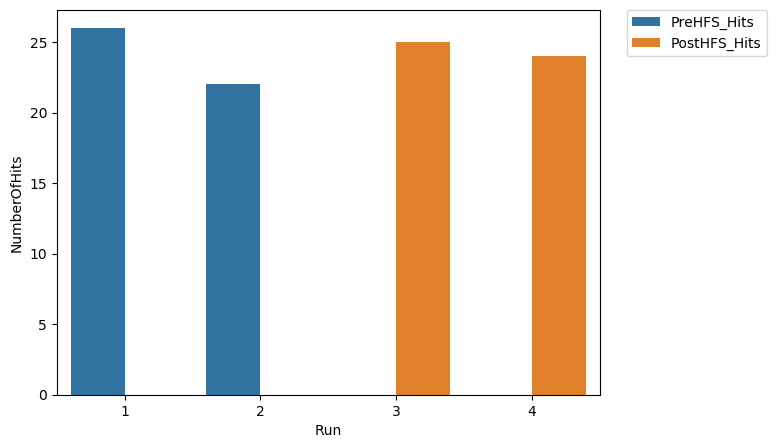

In [552]:
#Number of Hits plot
preHFS_hits = []
postHFS_hits = []
for k,v in hits.items():
    if k in preHFS:
        preHFS_hits.append(hits[k])
        
    if k in postHFS:
        postHFS_hits.append(hits[k])
        

fig_dims = (7,5)
fig, ax = plt.subplots(figsize=fig_dims)
df1=pd.DataFrame(preHFS_hits)
df2=pd.DataFrame(postHFS_hits)
df1['hue']= "PreHFS_Hits"
df2['hue']= "PostHFS_Hits"
res=pd.concat([df1,df2])
res.insert(0, "Run", range(1,5), True)
res.rename(columns = { 0 :'NumberOfHits'}, inplace = True) 
sns.barplot(data=res, x= 'Run', y = 'NumberOfHits', hue = 'hue' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


### Response Time

[Text(0, 0, '02_S0300_v0-r3hvAm.log'),
 Text(0, 0, '02_S0300_v0-r3hvBm.log'),
 Text(0, 0, '02_S0300_v0-r3hvDm.log'),
 Text(0, 0, '02_S0300_v0-r3hvCm.log')]

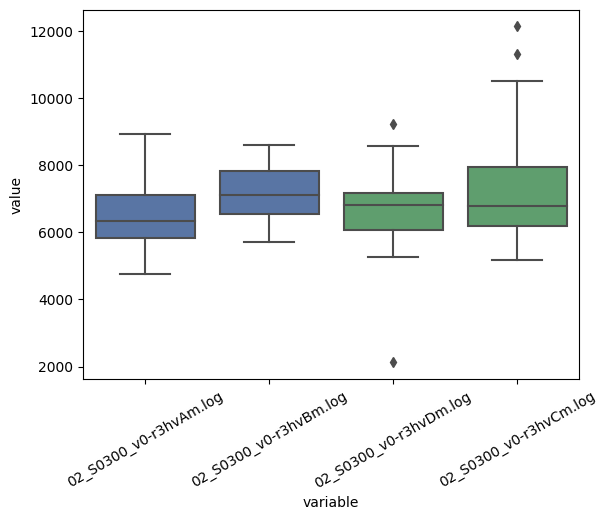

In [553]:
ResponseDF = ResponseDF[preHFS+postHFS]
hm = sns.boxplot(x="variable", y="value", data=pd.melt(ResponseDF), palette=["b", "b","g","g"])
# palette=["b", "b","g","g"]
hm.set_xticklabels(labels=ResponseDF.columns.values, rotation=30)


**Blue Color - PreHFS**


**Green Color - PostHFS**

In above graph as we can see, there is not much change in mean response time values in pre and post HFS.


### Number of FalseAlarm plot

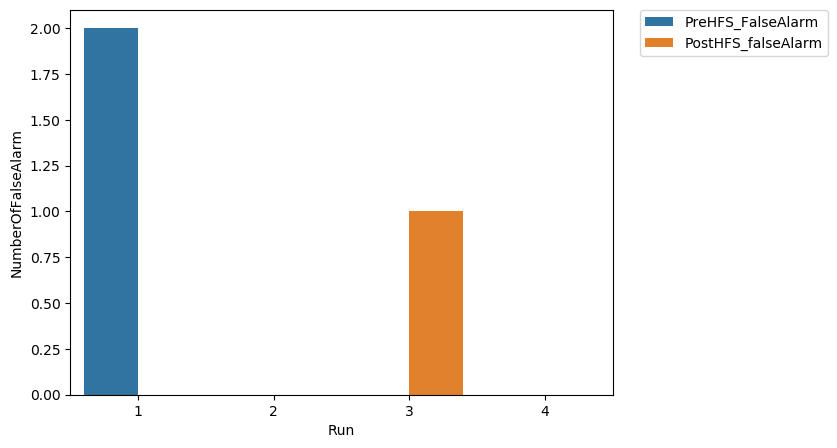

In [554]:
#Number of FalseAlarm plot
preHFS_falseAlarm = []
postHFS_falseAlarm = []
for k,v in falseAlarm.items():
    if k in preHFS:
        preHFS_falseAlarm.append(falseAlarm[k])
        
    if k in postHFS:
        postHFS_falseAlarm.append(falseAlarm[k])
        
fig_dims = (7,5)
fig, ax = plt.subplots(figsize=fig_dims)
df1=pd.DataFrame(preHFS_falseAlarm)
df2=pd.DataFrame(postHFS_falseAlarm)
df1['hue']= "PreHFS_FalseAlarm"
df2['hue']= "PostHFS_falseAlarm"
res=pd.concat([df1,df2])
res.insert(0, "Run", range(1,5), True)
res.rename(columns = { 0 :'NumberOfFalseAlarm'}, inplace = True) 
sns.barplot(data=res, x= 'Run', y = 'NumberOfFalseAlarm', hue = 'hue' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Number of Miss plot

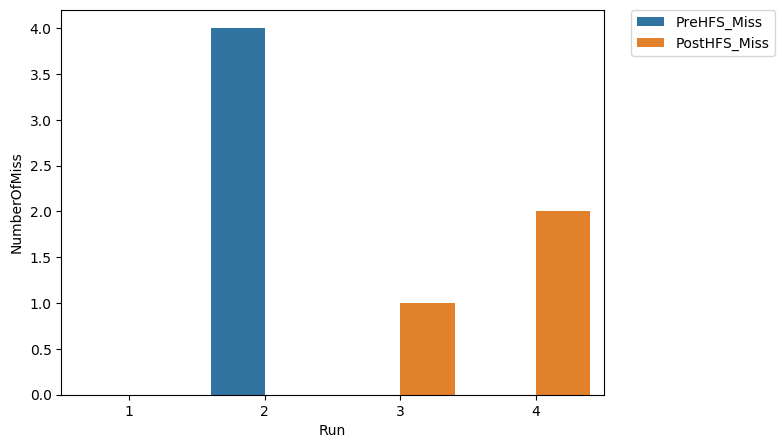

In [555]:
#Number of Miss plot
preHFS_Miss = []
postHFS_Miss = []
for k,v in miss.items():
    if k in preHFS:
        preHFS_Miss.append(miss[k])
        
    if k in postHFS:
        postHFS_Miss.append(miss[k])

fig_dims = (7,5)
fig, ax = plt.subplots(figsize=fig_dims)
df1=pd.DataFrame(preHFS_Miss)
df2=pd.DataFrame(postHFS_Miss)
df1['hue']= "PreHFS_Miss"
df2['hue']= "PostHFS_Miss"
res=pd.concat([df1,df2])
res.insert(0, "Run", range(1,5), True)
res.rename(columns = { 0 :'NumberOfMiss'}, inplace = True) 
sns.barplot(data=res, x= 'Run', y = 'NumberOfMiss', hue = 'hue' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [567]:
ResponseDF.mean().to_list
allResponsetimes_mean = []
allResponsetimes_mean.append(ResponseDF.mean().to_list())

In [568]:
allResponsetimes_mean

[[6520.428571428572, 7226.136363636364, 6638.384615384615, 7363.916666666667]]

In [572]:
[] + ResponseDF.mean().to_list()

[6520.428571428572, 7226.136363636364, 6638.384615384615, 7363.916666666667]

In [573]:
subjects_list = ['01_S0308_v0', '01_S0310_v0', '01_S0325_v0', '01_S0327_v0']

In [574]:
ResponseDF.median().to_list()

[6333.5, 7112.0, 6819.0, 6782.5]